# neurODE: Spring Model

This file gives a basic idea of the neurODE training strategy for fitting a mechanistically defined model to data using a spring system. Obviosly, this approach is overkill for a linear model like this, but it's a good starting point for orientation

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np 
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
from tools.keras_dynamicLayers import trainableInput, BiasLayer

Using TensorFlow backend.


## Build Model

The model assumes that there is a known stimulus acting on latent states to generate the observed data. The basic components are:

 - __Initial condition generator:__ In general we can't observe all latent states. We therefore must define and fit the "equilibrium" resting state where the latent system is at the beginning of each sample
 
 - __Dynamics simulation:__ The purpose of this whole repo is to fit mechanistic ODE models of what we think is happening with the benefit of gpu acceleration. The way we implement the model is as a RNN operating on the stimulus data U. Each timestep  of the ODE is implemented as a call to a custom RNN_cell in the tools folder (see import for details). It returns the complete latent state at each timestep
 
 - __Measurement__: Finally, we have to define how the latent state becomes our observed data. This can either be through known assumptions (e.g. a projection of one of the latent components as seen below) or a more complex trained projection.
 
Below is a basic version of model architecture. For more generalizations and considerations, see the neuralModel.

In [2]:
U = keras.layers.Input((None,2,),name='U_in')  #(n_times,number of stimuli)

#Initial condition generator
initial_condition = trainableInput(p_shape=(2,),initializer='zeros',trainable=False)
U_dummy = keras.layers.Lambda(lambda x: x[:,0,:])(U)
Q0 = initial_condition(U_dummy)

#dynamics simulator
from tools.keras_dynamicLayers_spring import rnnCell_spring_
THETA_cell = rnnCell_spring_(initializer='ones') #says what happens at each timepoint, where the mechanistic model is defined
THETA = keras.layers.RNN(THETA_cell,return_sequences=True) #what runs the mechanistic model
Q_hat = THETA(U,initial_state=[Q0,]) #predicted latent timeseries

#measurement (how does it go from latent dynamics to observed data?)
M = keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,1],axis=-1)) #project the location component of state
M2 = BiasLayer() #allow for mean shift
Z_hat = M(Q_hat)
Z_hat = M2(Z_hat)
Z_hat = keras.layers.Lambda(lambda x: K.squeeze(x,-1))(Z_hat)

#put together the model
model = keras.models.Model(inputs=[U],outputs=[Z_hat])
opt = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=opt,loss='mse',)
#model that leaves it in latent space
latent_model = keras.models.Model(inputs=[U], outputs=[Q_hat])

#set some initial states
w = THETA.get_weights()
w[-1] = np.eye(2)
THETA.set_weights(w)

in,state (?, 2) (?, 2)
pre-op (?, 2)
input-op (?, 2)
X_new (?, 2)
in,state (?, 2) (?, 2)
pre-op (?, 2)
input-op (?, 2)
X_new (?, 2)


In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
U_in (InputLayer)               (None, None, 2)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2)            0           U_in[0][0]                       
__________________________________________________________________________________________________
trainable_input_1 (trainableInp (None, 2)            2           lambda_1[0][0]                   
__________________________________________________________________________________________________
rnn_1 (RNN)                     (None, None, 2)      10          U_in[0][0]                       
                                                                 trainable_input_1[0][0]    

## Training

Demo of training. Here we are training on response of planarian flatworms to a sinusoidal UV stimulation

dict_keys(['tau', '093022WT_30m_1mPeriod', '093022WT_30m_3mPeriod', '093022WT_30m_10mPeriod', '093022WT_30m_30sPeriod', '093022WT_30m_2mPeriod', '093022WT_30m_5mPeriod', '100622WT_30m_5mPeriod', '100622WT_30m_4mPeriod', '101422WT_30m_6mPeriod', '101422WT_30m_8mPeriod', '101422WT_30m_9mPeriod', '101822WT_30m_3mPeriod_amp64bp', '101822WT_30m_2mPeriod_amp64bp', '101722WT_30m_11mPeriod', '101722WT_30m_10mPeriod', '101722WT_30m_2mPeriod_amp32bp', '101722WT_30m_3mPeriod_amp32bp', '101722WT_30m_4mPeriod_amp32bp', '102122WT_30m_15mPeriod', '102122WT_30m_13mPeriod', '102122WT_30m_12mPeriod', '102422WT_30m_150sPeriod', '102422WT_30m_210sPeriod', '102422WT_30m_270sPeriod', '102422WT_30m_330sPeriod', '102422bWT_30m_5mPeriod', '102422aWT_30m_5mPeriod', '101822pc2_30m_10mPeriod', '101822pc2_30m_3mPeriod'])
WT_30m_30s
['093022WT_30m_30sPeriod']
WT_30m_1m
['093022WT_30m_1mPeriod']
WT_30m_2m
['093022WT_30m_2mPeriod']
WT_30m_150s
['102422WT_30m_150sPeriod']
WT_30m_3m
['093022WT_30m_3mPeriod']
WT_30m_210

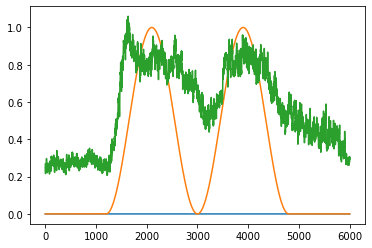

In [4]:
## Build the training data set
interest='WT'
periods = [.5,1,2,2.5,3,3.5,4,4.5,5,6,8,9,10,11,12,13,15]
duration=30
UU = []
ZZ = []

import pickle
def data_of_interest(names,interest=[],exclude=[]):
    to_plot = []
    full_amp = True
    for i in interest:
        if 'amp' in i and not '127amp' in i:
            full_amp=False
    if full_amp:
        exclude.append('amp')
    for dat in names:
        if dat in to_plot: continue
        for i in interest:
            if i in dat:
                keep = True
                for ex in exclude:
                    if ex in dat: keep = False
                #check double/triple knockdown
                if dat.count('+')>i.count('+'):
                    print(dat)
                    keep=False
                if keep: to_plot.append(dat)
    return to_plot

name = 'data/LDS_response_sinFunc.pickle'
with open(name,'rb') as f:
    result = pickle.load(f)
print(result.keys())
for i,p in enumerate(periods):
    xp = result['tau']
    ind_t = np.where((xp>=-10)&(xp<=40))[0]
    p_name = f'{p}m'
    if p<1 or p%1>0:
        p_name = f'{int(p*60)}s'

    print(f'{interest}_{duration}m_{p_name}')
    to_plot = data_of_interest(result.keys(),[f'{interest}_{duration}m_{p_name}'],)
    print(to_plot)
    xp = result['tau']
    yp = np.concatenate([result[dat]['data'] for dat in to_plot])
    
    UU.append(np.array([ind_t*0,result[to_plot[0]]['stim'][ind_t]]).T)
    ZZ.append(np.median(yp,axis=0)[ind_t])
plt.plot(UU[-1])
plt.plot(ZZ[-1])

augment=1000
# UU = np.array(UU)
# ZZ = np.array(ZZ)
UU = np.concatenate([UU for i in range(augment)])
ZZ = np.concatenate([ZZ for i in range(augment)])

#### Fit the data

In [ ]:
ind = np.arange(UU.shape[0])
np.random.shuffle(ind)
model.fit(UU[ind],ZZ[ind],epochs=20,batch_size=32)

In [6]:
pred = model.predict(UU[:len(periods)],batch_size=256)


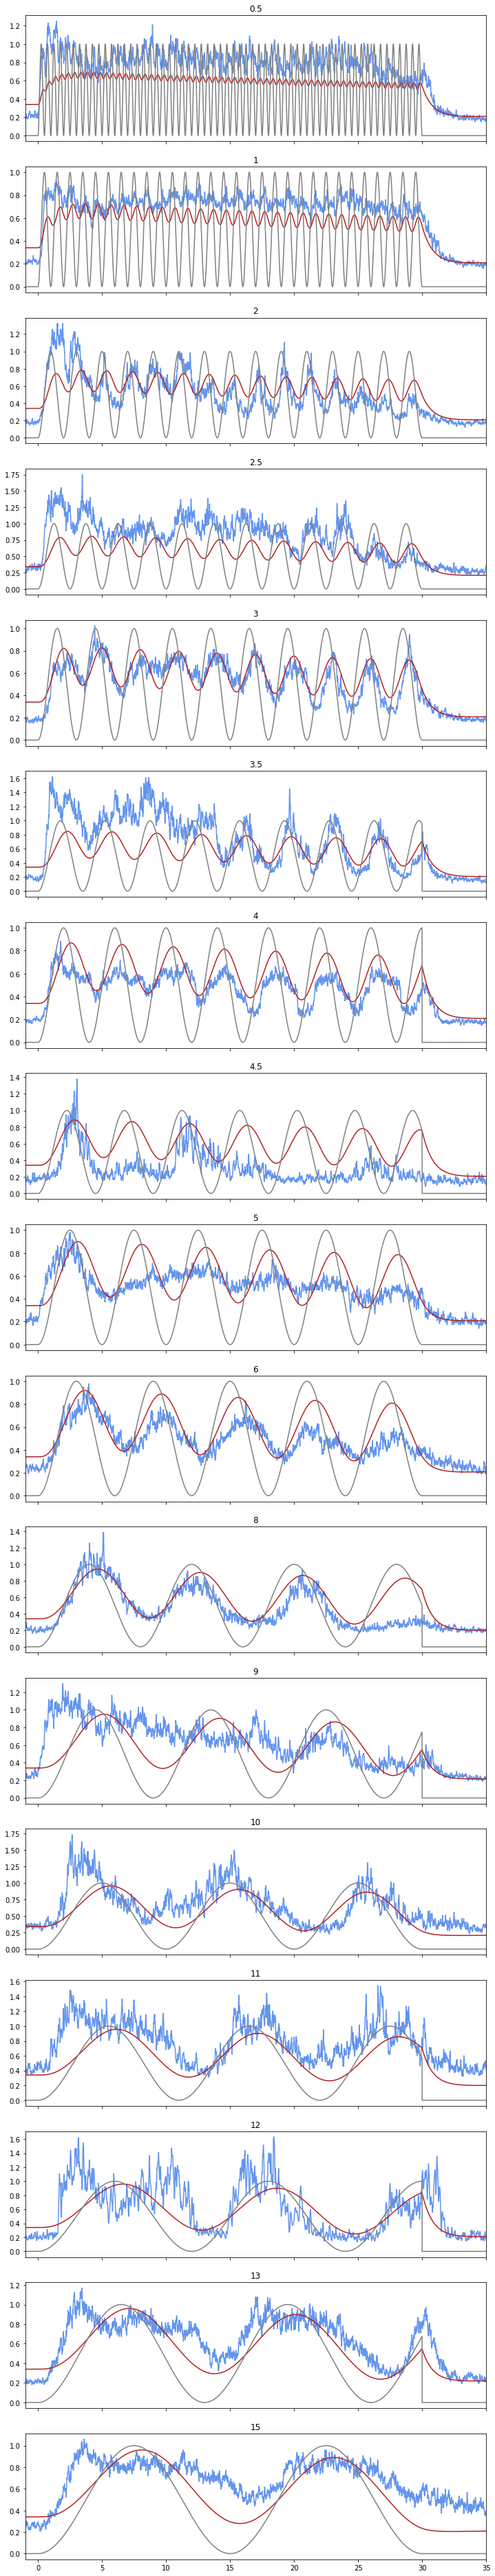

In [7]:
sub=1
fig,ax = plt.subplots(nrows=len(periods)//sub,figsize=(12,4*len(periods)//sub),sharex=True)
for i,a in enumerate(ax):
    tp = xp[ind_t]
    a.plot(tp,ZZ[i*sub,],c='cornflowerblue')
    a.plot(tp,pred[i*sub],c='firebrick')
    a.plot(tp,UU[i*sub,:,1],c='grey')
    a.set_title(periods[i*sub])
plt.xlim(-1,35)
fig.savefig('plots/springFit.png')

## Parameter evaluation

We can now see what the parameters of the underlying ODE are!

In [6]:
for w,val in zip(THETA_cell.weights,THETA.get_weights()):
    print(f'{w.name}: {val}')

rnn_1/k:0: [1.]
rnn_1/b:0: [1.]
rnn_1/input_mat:0: [[1. 1.]
 [1. 1.]]
rnn_1/input_mask:0: [[1. 0.]
 [0. 1.]]
